# First run through

This is my first run through of getting what needed done, done

I will walk through what I am doing 

Couldnt figure out how to input datafiles into this notebook from google drive

Once that is situated, saving files there and loading files should be pretty easily done but couldnt figure out how to use pydrive yet

In [2]:
# used for system file finding (expects linux or mac)
import glob

# used for numerical calculations
import numpy as np

# used to make dataframes (somewhat similar to an excel sheet)
import pandas as pd

# used for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# uncomment the line below to install soundfilea
# !pip install soundfile

# used to transform the 24 bit wav file to 32 bit
# since scipy.io.wavfile wont accept 24 bit
import soundfile as sf

# used to transform the wav file to numpy array
from scipy.io import wavfile

# used to make the spectrogram
from scipy import signal

# importing the calculating function you guys created
from beamforming_calculations import ComputeDeltaT

# used to make buttons and sliders and playable audio
from IPython.display import Audio, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# checks in current folder for all files that end with .WAV
# expects that the file youre looking for is in the same folder as this notebook
files = glob.glob('*.WAV')

# makes the button to chose witch file we want to try
file_choose = widgets.Dropdown(
    options=files,
    description='Chose your File:',
    disabled=False,
)

# this is how to make the submit button
button = widgets.ToggleButton(
    value=False,
    description='Submit',
    disabled=False,
    tooltip='Description',
)

# makes and shows file chosing button
w1 = interactive(lambda x: x, x=file_choose)
display(w1)

# this is how we get the file chosen from the button
def f(x):
    # global is usually a bad choice but
    # needed to return these variables from the button
    global data, rate
    
    # checks for when the button has been clicked
    if x == True:
        
        # gets the file chosen
        file_chosen = w1.children[0].value
        
        # uses soundfile to read 24 bit file
        data, samplerate = sf.read(file_chosen)
        
        # writes temp file that is 32 bit 
        sf.write('new.wav', data, samplerate, subtype='PCM_32')
        rate, data = wavfile.read('new.wav')
        print '{} converted and loaded'.format(file_chosen)
        return data, rate

# shows the submit button
w2 = interactive(f, x=button)
display(w2)

[0.0031782407198262764, 0.002993672038777123, 0.0028270212050864785, 0.0026816308336383167]


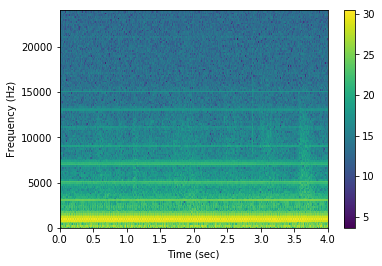

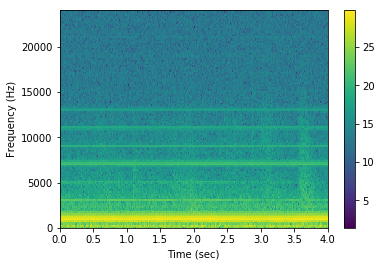

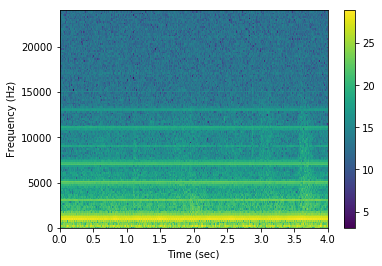

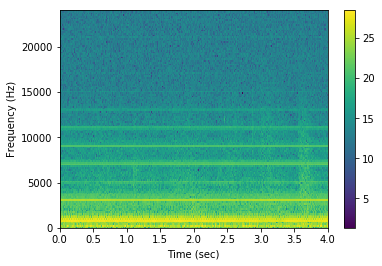

In [5]:
# plots each microphones spectrogram
for mic in range(4):
    f, t, Sxx = signal.spectrogram(data[:,mic],rate)
    Sxx = np.log(Sxx)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.pcolormesh(t,f,Sxx)
    plt.colorbar()
    plt.show()

In [6]:
# makes the times range slider
times = widgets.FloatRangeSlider(
    value=[0, len(data)/float(rate)],
    min=0,
    max=len(data)/float(rate),
    step=0.01,
    description='Times',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )

# shows the times slider
w3 = interactive(lambda x: x, x=times)
display(w3)

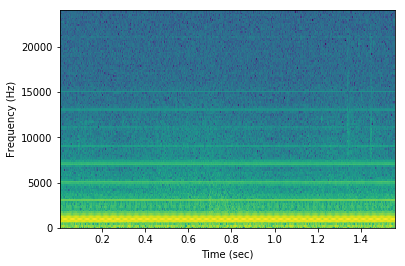

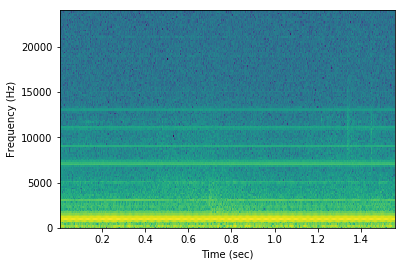

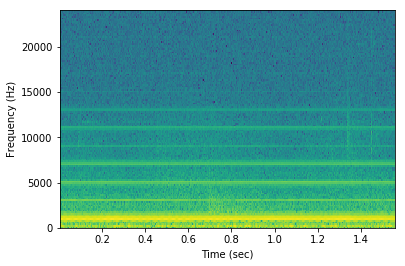

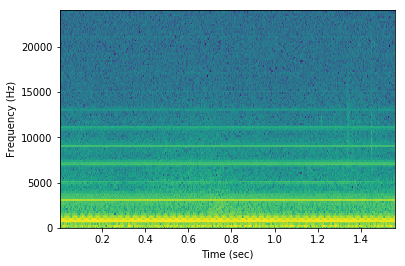

In [9]:
# turns the times you chose into variables
# makes then ints and makes sure they grab the right indicies
t0, t1 = [int(x*rate) for x in w3.children[0].value]

# plot the spectrogram on the chosen time range
for mic in range(4):
    f, t, Sxx = signal.spectrogram(data[t0:t1,mic],rate)
    Sxx = np.log(Sxx)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.pcolormesh(t,f,Sxx)
    plt.show()

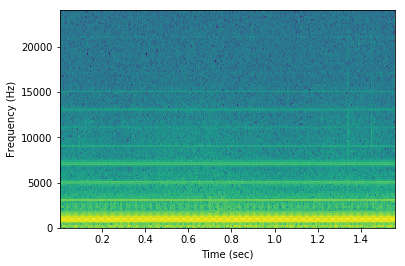

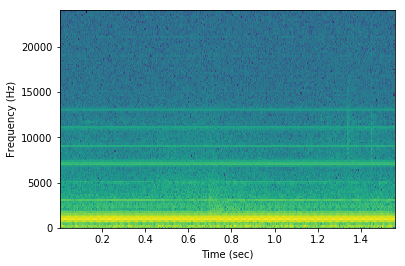

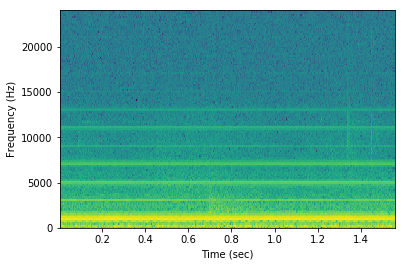

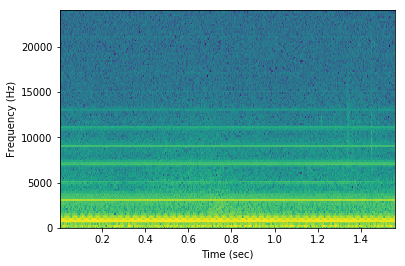

In [10]:
# setting up the mic array geometry
micArrayGeometry = [-0.15, -0.05, 0.05, 0.15]

# setting up the location
# angle range of virtual beam
alpha = 125 
# distance from virtual beam point to target object, in meters
d = 1 

# computing the amount the array needed shifting
micDeltaT = np.asarray([ComputeDeltaT(x,d,alpha) for x in micArrayGeometry])

# shift the array
# later could make it such it cut off other values rolled around
rollVals = list(map(int,(micDeltaT-min(micDeltaT))*rate))

# brought all the shifted wav channels back together
shifted_data = []
for mic, val in enumerate(rollVals):
    shifted_data.append(np.roll(data[:,mic],val))
shifted_data = np.asarray(shifted_data).T


# plotting the shifted wave channels
for mic in range(4):
    f, t, Sxx = signal.spectrogram(shifted_data[t0:t1,mic],rate)
    Sxx = np.log(Sxx)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.pcolormesh(t,f,Sxx)
    plt.show()

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<IPython.core.display.Javascript object>


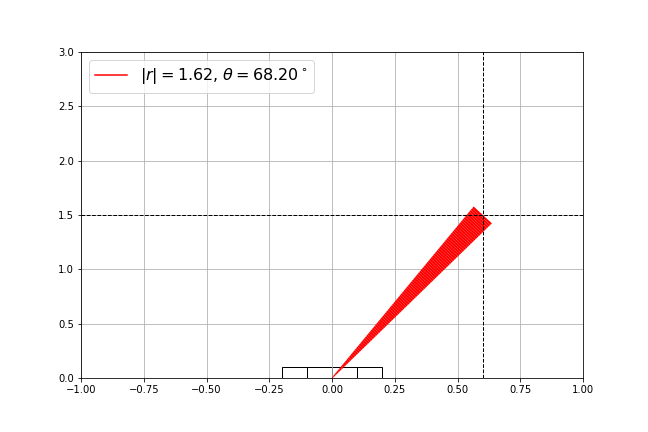

In [12]:
# if widgets fail, try using this line below in terminal
!jupyter nbextension enable --py widgetsnbextension

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interactive
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(-2,3),range(-2,3),alpha=0)

vline = ax.axvline(1, color='k',linestyle='--',linewidth=1)
hline = ax.axhline(0.5, color='k',linestyle='--',linewidth=1)


line = ax.plot([0,1],[0,1],color='r')[0]

width = np.linspace(1,25,100)

def set_cursor(x, y):
    ax.clear()
    
    # add little squares for the mic array
    for mic_X in micArrayGeometry:
        ax.add_patch(patches.Rectangle((mic_X-.05,0), 0.1, 0.1,edgecolor='black',facecolor='none'))

    vline = ax.axvline(1, color='k',linestyle='--',linewidth=1)
    hline = ax.axhline(0.5, color='k',linestyle='--',linewidth=1)
    
    vline.set_xdata((x, x))
    hline.set_ydata((y, y))

    ax.set_xlim([-1,1])
    ax.set_ylim([0,3])

    xs = np.linspace(0,x,100)
    ys = np.linspace(0,y,100)
    
    line.set_xdata(xs)
    line.set_ydata(ys)
    

    segments = np.array(zip(xs,ys)).reshape(-1,1,2)
    segments = np.concatenate([segments[:-1], segments[1:]], axis=1)
    lc = LineCollection(segments, linewidths=width, color='red')
    ax.add_collection(lc)

    theta = np.arctan2(y,x) * 180 / np.pi
    r = (x**2+y**2)**(0.5)
    
    ax.legend([line],[r'$|r|={:.2f}$, $\theta={:.2f}^\circ$'.format(r,theta)],fontsize=16)
    ax.grid()
    ax.figure.canvas.draw_idle()
    ax.legend()

set_cursor(1,1) 
interactive(set_cursor, x=ax.get_xlim(), y=ax.get_ylim())

In [13]:
# not sure how to add all the channels together
# tried using the mean, anything could be used
stacked_data = np.asarray([np.mean(x) for x in data[t0:t1]])

# make playable audio of the data of the first channel
# make playable audio of the mean of the channels
A1 = Audio(data[t0:t1,0],rate=rate)
A2 = Audio(stacked_data,rate=rate)

# took the mean of the stacked data
stacked_shifted_data = np.asarray([np.mean(x) for x in shifted_data[t0:t1]])

# make playable audio of the data of the first channel of the shifted data
# make playable audio of the mean of the channels of the shifted data
A3 = Audio(shifted_data[t0:t1,0],rate=rate)
A4 = Audio(stacked_shifted_data,rate=rate)

# show the playable audio
# display(A1)
display(A2)
# display(A3)
display(A4)

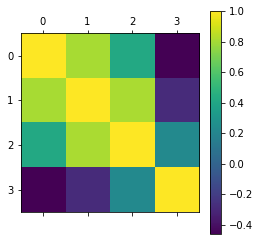

0.50269551278


In [16]:
# find correlations of the different channels
%matplotlib inline
data_df = pd.DataFrame(data[t0:t1,:])
plt.matshow(data_df.corr())
plt.colorbar()
plt.show()

# find the average correlation between channels
print (sum(np.ravel(np.abs(data_df.corr())))-4)/(2.*6)

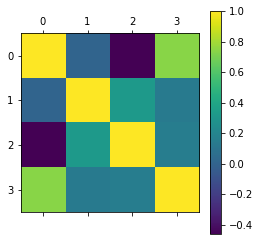

0.910395073902


In [17]:
# find correlations of the different channels for shifted data
shifted_data_df = pd.DataFrame(shifted_data[t0:t1,:])
plt.matshow(shifted_data_df.corr())
plt.colorbar()
plt.show()

# find the average correlation between channels for shifted data
print (sum(np.ravel(shifted_data_df.corr()))-4)/2.

In [18]:
# save shifted data to .wav file
wavfile.write('shifted_data.wav',rate,shifted_data[t0:t1,:])